# Telecom Churn Prediction 

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write more and more code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [84]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
data = data.set_index('id')

In [5]:
data.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
id                    ...                                                   
0    87.009    7.527  ...            0            0        NaN        NaN   
1   122.787   42.953  ...            0            0        NaN        1.0   
2   103.176    0.000  ...            0            0        NaN        NaN   
3   205.260  111.095  ...            0            0        NaN        NaN   
4   128.191  101.565  ...            1            0        1.0        1.0   

    fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
id                                                                          
0         NaN  1958         0.0         0.0         0.0                  0  
1         NaN   710         0.0         0.0         0.0                  0  
2         NaN   882         0.0         0.0         0.0                  0  
3         NaN   982         0.0         0.0         0.0                  0  
4         1.0   647         0.0         0.0         0.0                  0  

[5 rows x 171 columns]

Let's look at each variable's datatype:

In [6]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam

Removing the date columns as they are not usefull for predictions

In [7]:
date_cols =  [col for col in data if 'date' in col]
#removing date columns
data.drop(date_cols,axis=1,inplace=True)
data.shape

(69999, 162)

Let's also summarize the features using the df.describe method:

In [8]:
data.describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69297.0         69297.0         69297.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  66296.000000  ...  69999.000000  69999.000000  17568.000000   
mean     132.978257  ...      0.081444      0.085487      0.916325   
std      311.896596  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.410000  ...      0.000000      0.000000      1.000000   
50%       32.100000  ...      0.000000      0.000000      1.000000   
75%      115.060000  ...      0.000000      0.000000      1.000000   
max    10752.560000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 162 columns]

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [9]:
data['circle_id'].unique()

array([109], dtype=int64)

In [10]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 160), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 160), (14000, 160), (55999,), (14000,))

In [12]:
X_train.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6   arpu_7  \
id                                                                         
37870             0.0             0.0             0.0    44.210    0.000   
37978             0.0             0.0             0.0   159.446    0.300   
48343             0.0             0.0             0.0    93.785  342.885   
35319             0.0             0.0             0.0  1090.075  659.300   
5210              0.0             0.0             0.0   189.879  146.250   

        arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  ...  \
id                                                                   ...   
37870  297.773         0.00          NaN       112.61          4.81  ...   
37978   49.488       105.68         0.51        60.56         72.58  ...   
48343  472.826        25.86        53.64        21.23         70.61  ...   
35319  974.759       196.99        70.01       251.91       1222.56  ...   
5210   332.380        21.19        20.66        26.31         94.49  ...   

       sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
id                                                                              
37870            0            0            0        1.0        NaN        NaN   
37978            0            0            0        NaN        NaN        NaN   
48343            0            0            1        NaN        1.0        1.0   
35319            0            1            0        1.0        1.0        1.0   
5210             0            0            0        NaN        NaN        NaN   

        aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
id                                               
37870   831        0.00        0.00         0.0  
37978   228        0.00        0.00         0.0  
48343  1829        6.47      133.83         0.0  
35319  1214     1729.06     1151.35         0.0  
5210   3190        0.00        0.00         0.0  

[5 rows x 160 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

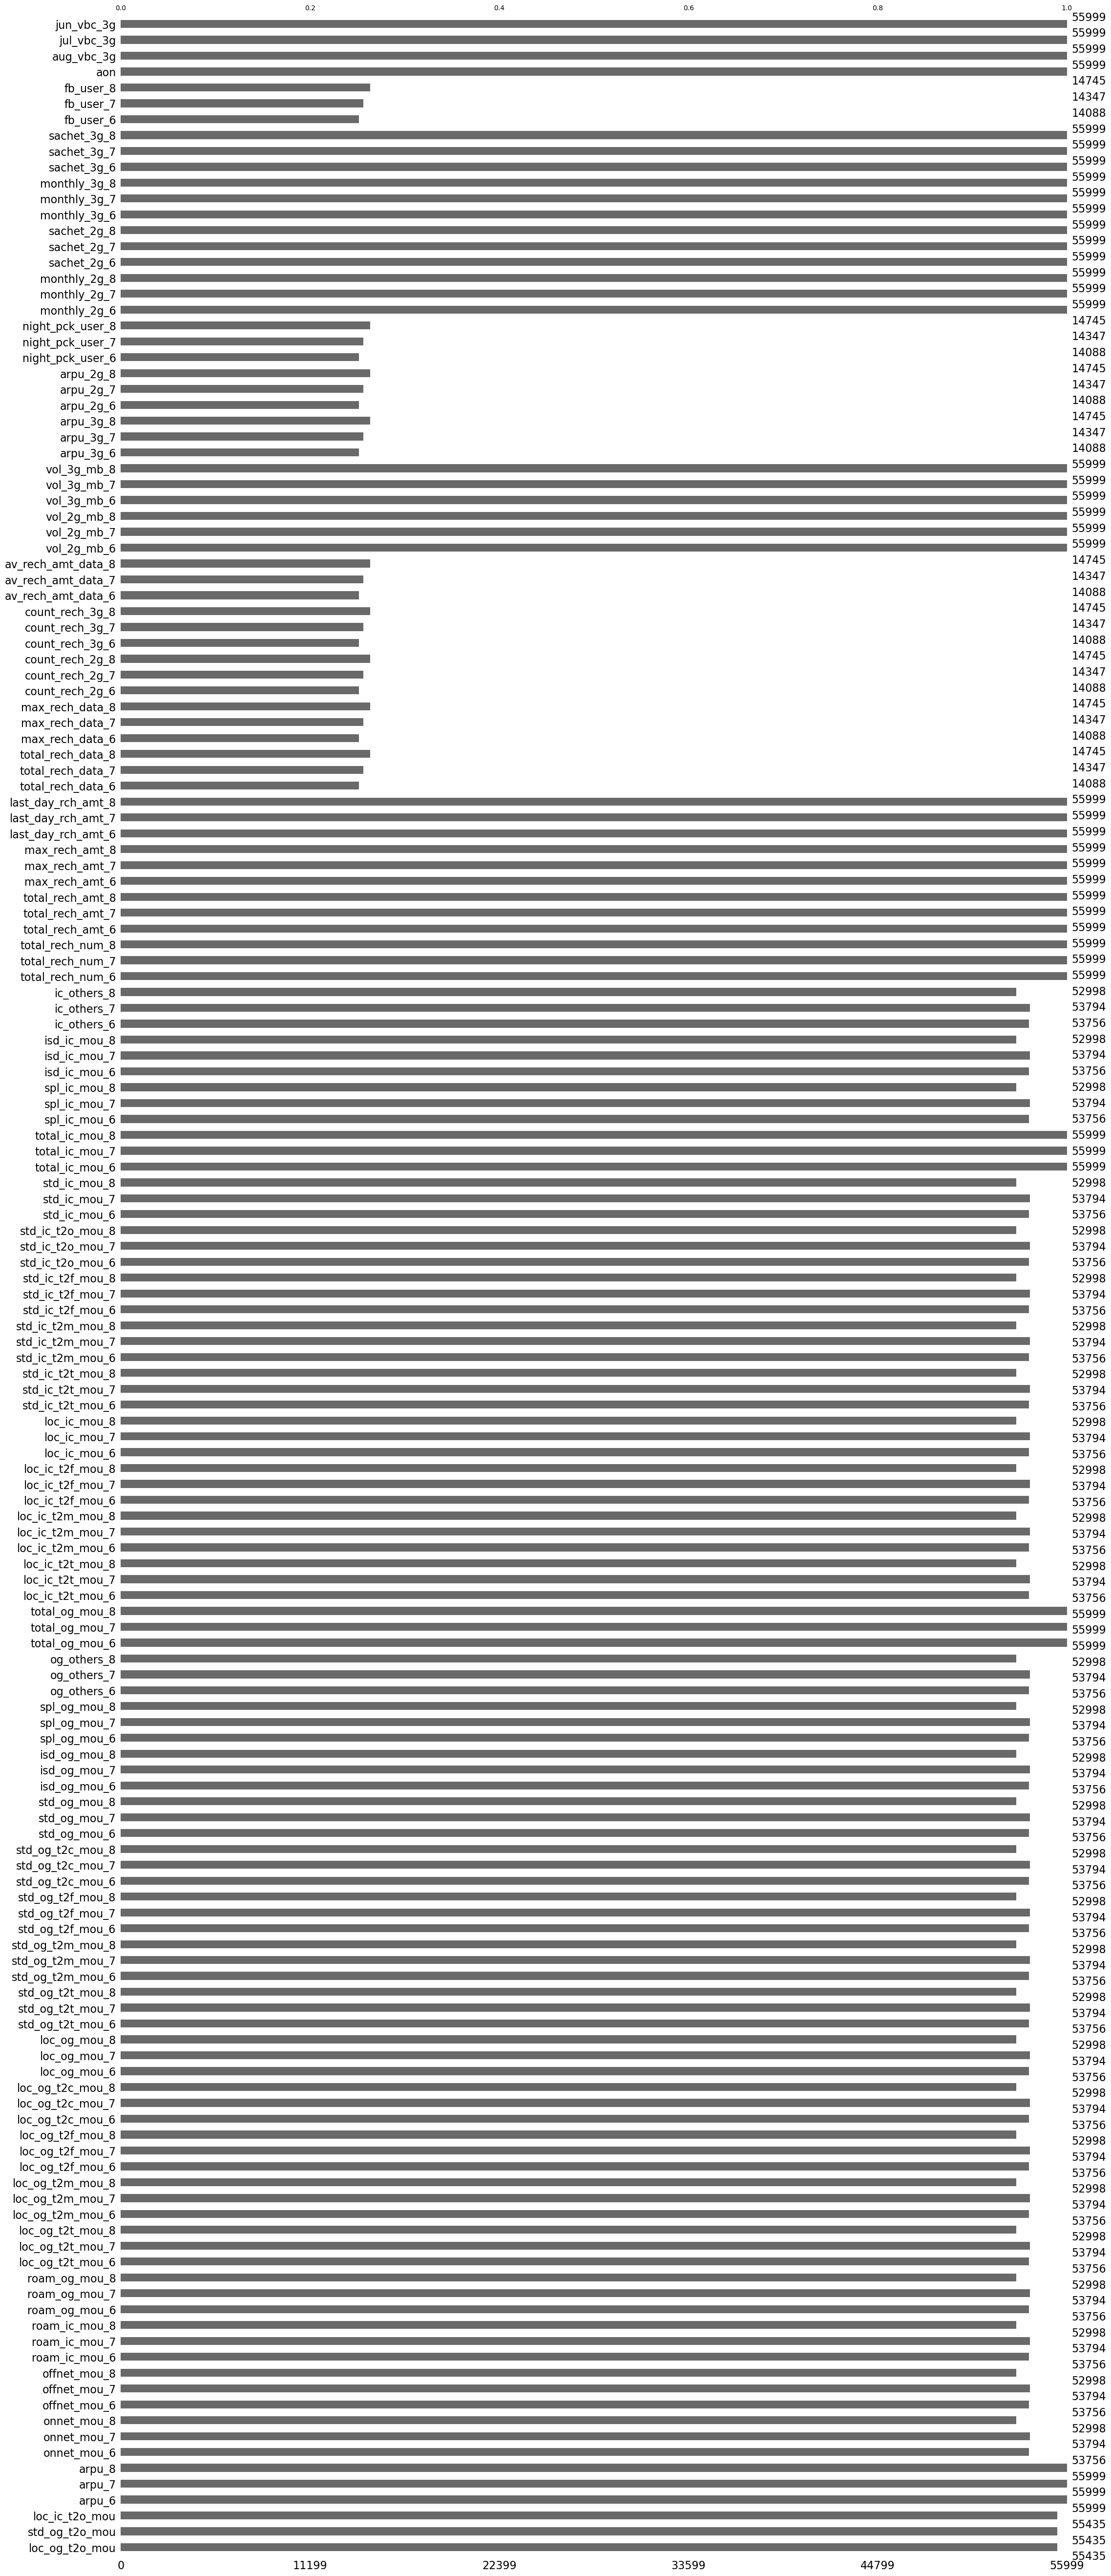

In [13]:
msno.bar(X_train)

Lets also calculate the % missing data for each column:

In [14]:
missing_data_percent = round(X_train.isna().sum() / len(X_train) * 100, 2).sort_values(ascending=False)
missing_data_percent

night_pck_user_6     74.84
max_rech_data_6      74.84
arpu_2g_6            74.84
fb_user_6            74.84
total_rech_data_6    74.84
                     ...  
vol_3g_mb_8           0.00
total_rech_num_6      0.00
total_ic_mou_8        0.00
total_ic_mou_7        0.00
jun_vbc_3g            0.00
Length: 160, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [15]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['std_ic_t2f_mou_8', 'og_others_8', 'loc_ic_mou_8', 'spl_ic_mou_8',
       'isd_og_mou_8', 'loc_og_t2t_mou_8', 'spl_og_mou_8', 'std_ic_mou_8',
       'loc_og_t2m_mou_8', 'std_ic_t2o_mou_8',
       ...
       'total_ic_mou_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'total_rech_num_6', 'total_ic_mou_8',
       'total_ic_mou_7', 'jun_vbc_3g'],
      dtype='object', length=133)

In [16]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 133)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

In this case, we will use a simple imputation with constant values as zeros.

In [17]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['std_ic_t2f_mou_8', 'og_others_8', 'loc_ic_mou_8', 'spl_ic_mou_8',
       'isd_og_mou_8', 'loc_og_t2t_mou_8', 'spl_og_mou_8', 'std_ic_mou_8',
       'loc_og_t2m_mou_8', 'std_ic_t2o_mou_8', 'std_og_t2c_mou_8',
       'loc_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'loc_ic_t2m_mou_8',
       'std_ic_t2t_mou_8', 'loc_ic_t2f_mou_8', 'isd_ic_mou_8', 'std_og_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'loc_og_t2c_mou_8',
       'onnet_mou_8', 'loc_og_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'loc_og_t2f_mou_8', 'ic_others_8', 'roam_og_mou_8', 'std_og_t2f_mou_8',
       'roam_og_mou_6', 'offnet_mou_6', 'std_ic_t2t_mou_6', 'onnet_mou_6',
       'std_ic_t2m_mou_6', 'spl_ic_mou_6', 'std_ic_t2f_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'std_ic_t2o_mou_6',
       'isd_ic_mou_6', 'roam_ic_mou_6', 'std_ic_mou_6', 'ic_others_6',
       'loc_ic_mou_6', 'isd_og_mou_6', 'loc_ic_t2t_mou_6', 'std_og_t2c_mou_6',
       'std_og_t2f_mou_6', 'spl_og_mou_6', 'og_others_6', 'std_og_

In [18]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

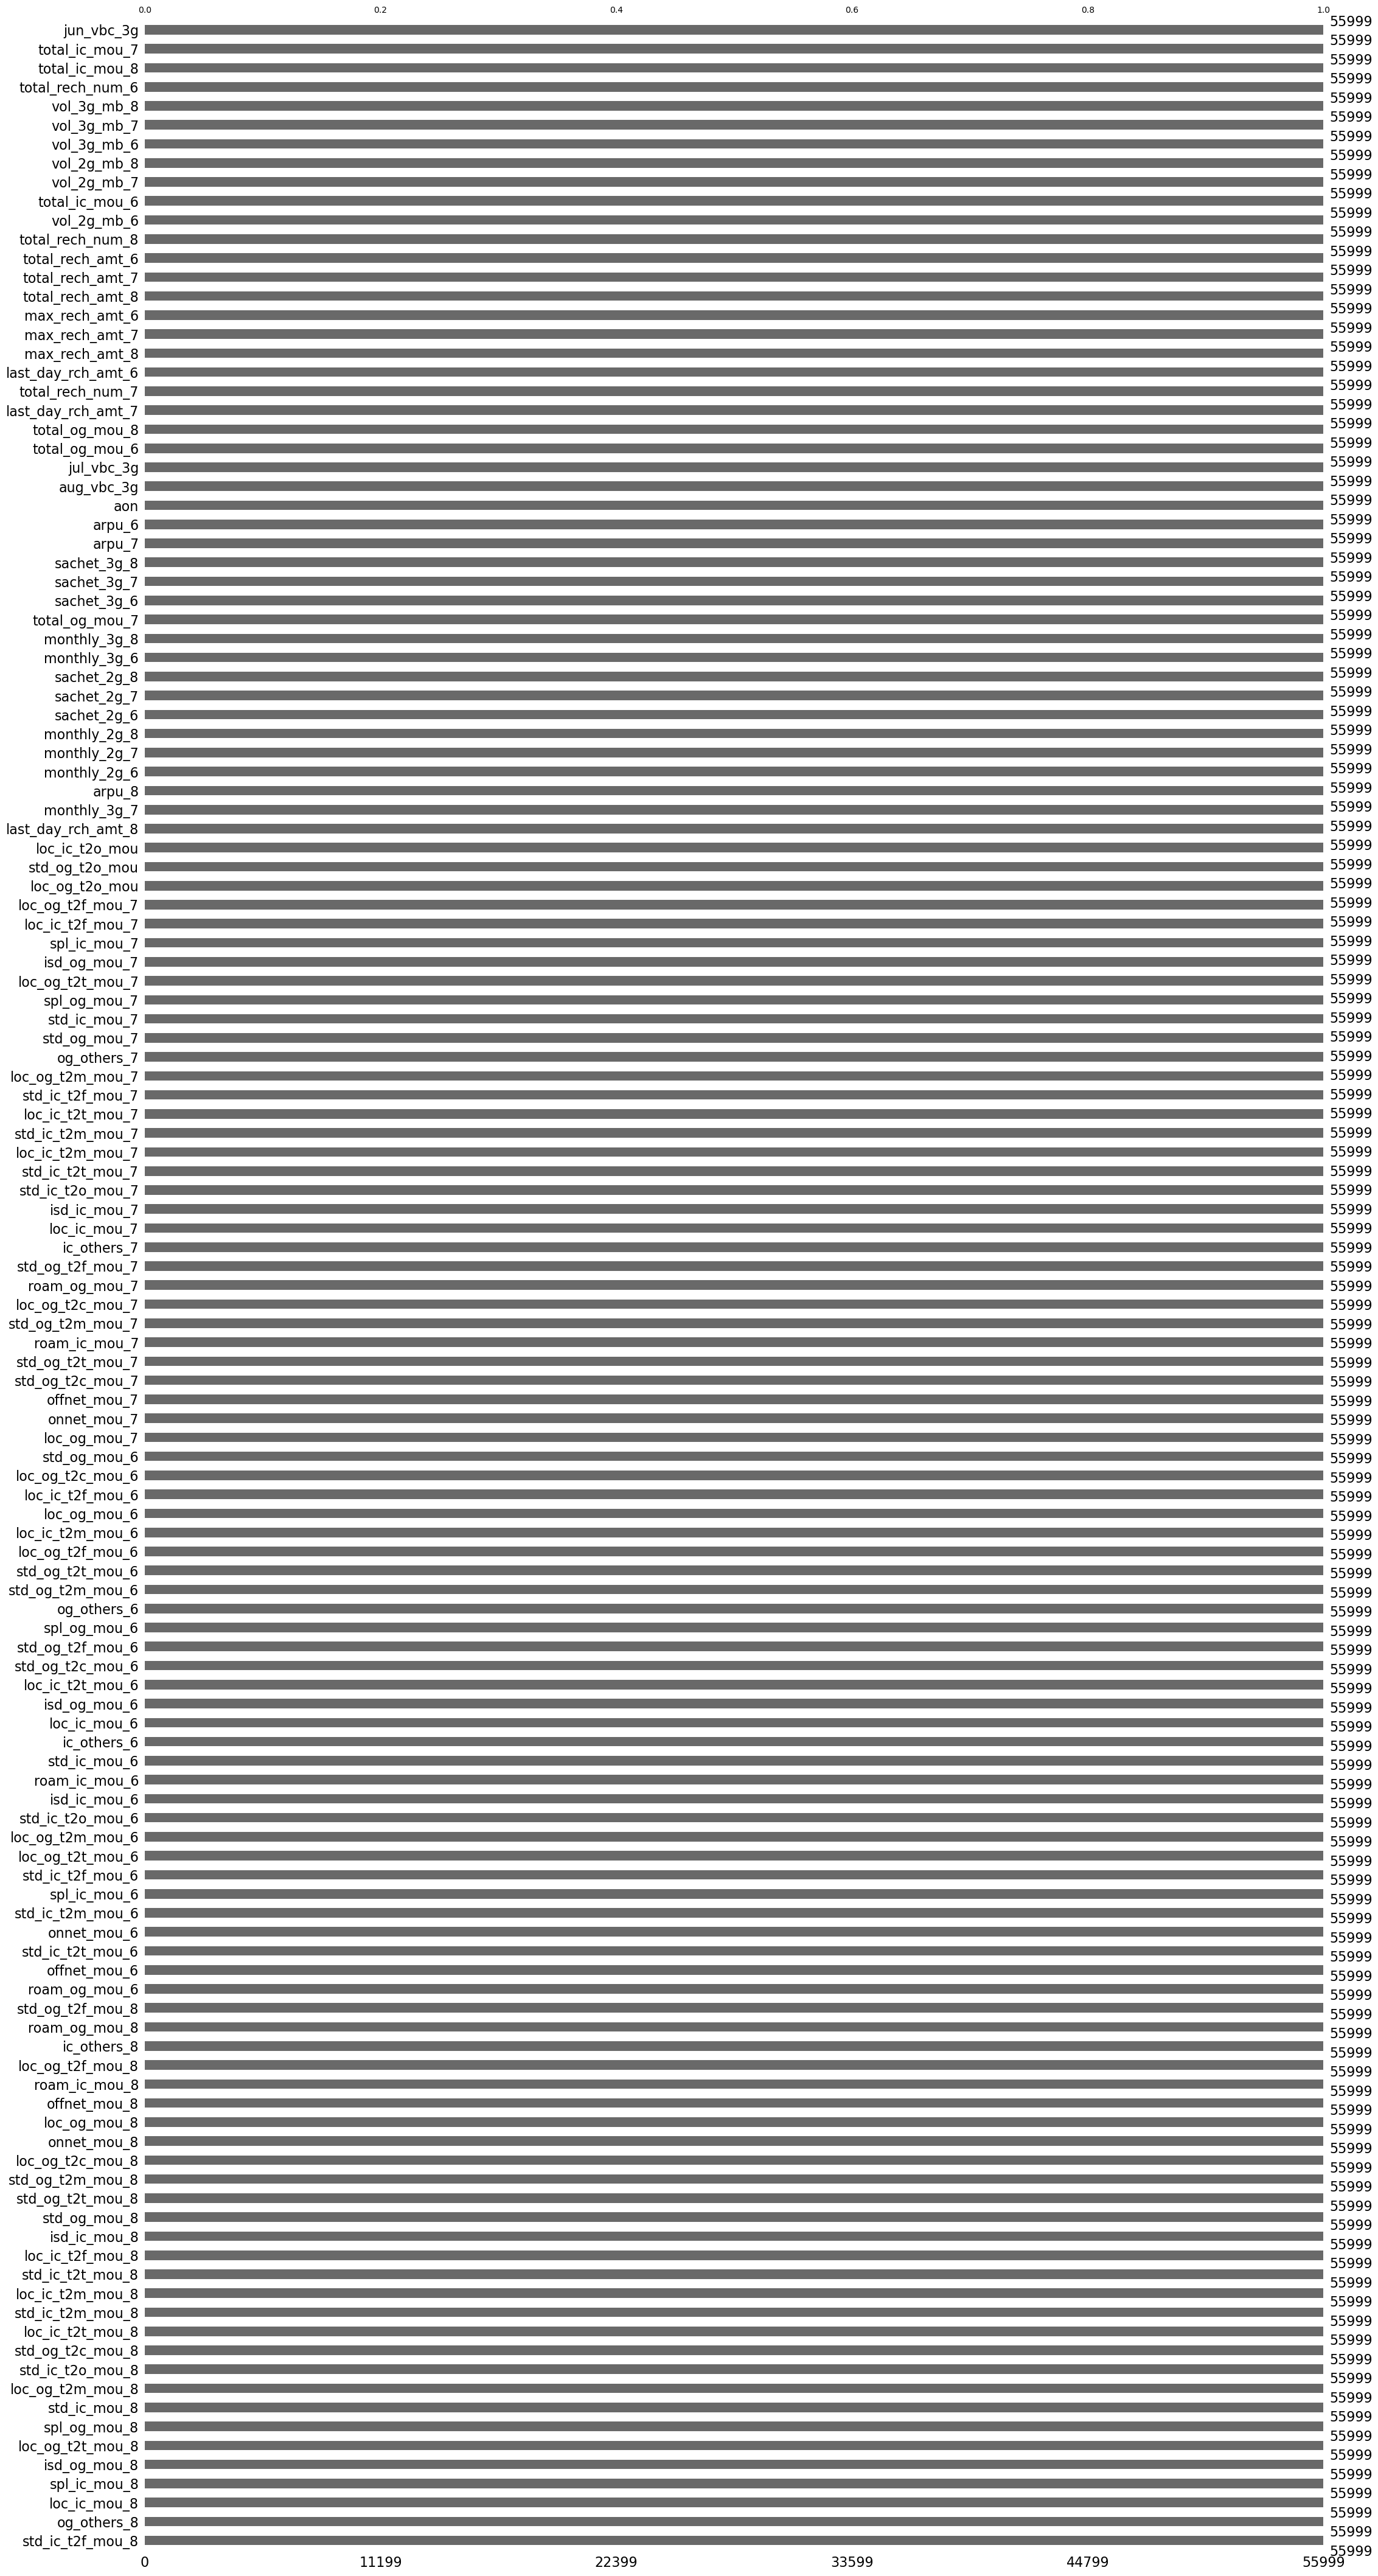

In [19]:
msno.bar(X_train_filtered)

In [20]:
X_train_filtered.describe()

std_ic_t2f_mou_8   og_others_8  loc_ic_mou_8  spl_ic_mou_8  \
count      55999.000000  55999.000000  55999.000000  55999.000000   
mean           1.995127      0.028162    158.367225      0.038308   
std           15.806045      1.741992    245.125526      0.148577   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000     24.760000      0.000000   
50%            0.000000      0.000000     84.580000      0.000000   
75%            0.000000      0.000000    197.510000      0.000000   
max         1394.890000    286.360000   6458.280000     16.860000   

       isd_og_mou_8  loc_og_t2t_mou_8  spl_og_mou_8  std_ic_mou_8  \
count  55999.000000      55999.000000  55999.000000   55999.00000   
mean       0.699333         42.997869      4.845460      31.46372   
std       20.209555        145.094410     18.051125     104.44242   
min        0.000000          0.000000      0.000000       0.00000   
25%        0.000000          0.780000      0.000000       0.00000   
50%        0.000000         10.110000      0.000000       4.69000   
75%        0.000000         37.310000      3.560000      25.61000   
max     3629.910000      10752.560000   1075.080000    3930.24000   

       loc_og_t2m_mou_8  std_ic_t2o_mou_8  ...  total_ic_mou_6   vol_2g_mb_7  \
count      55999.000000           55999.0  ...    55999.000000  55999.000000   
mean          86.033397               0.0  ...      199.972396     51.231798   
std          150.006129               0.0  ...      291.482136    212.874644   
min            0.000000               0.0  ...        0.000000      0.000000   
25%            6.410000               0.0  ...       38.635000      0.000000   
50%           35.810000               0.0  ...      114.880000      0.000000   
75%          102.860000               0.0  ...      251.340000      0.000000   
max         4961.330000               0.0  ...     7716.140000   7873.550000   

        vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000   
mean      50.180530    123.936335    129.450929    135.908424   
std      215.667832    567.967322    544.704714    568.633073   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000   
max    11117.610000  45735.400000  27600.290000  30036.060000   

       total_rech_num_6  total_ic_mou_8  total_ic_mou_7    jun_vbc_3g  
count      55999.000000    55999.000000    55999.000000  55999.000000  
mean           7.536117      198.720158      201.949991     61.095175  
std            6.997056      288.309042      295.795451    263.397967  
min            0.000000        0.000000        0.000000      0.000000  
25%            3.000000       38.240000       41.010000      0.000000  
50%            6.000000      114.340000      116.160000      0.000000  
75%            9.000000      249.170000      249.635000      0.000000  
max          170.000000     6476.360000     9699.010000  11166.210000  

[8 rows x 133 columns]

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

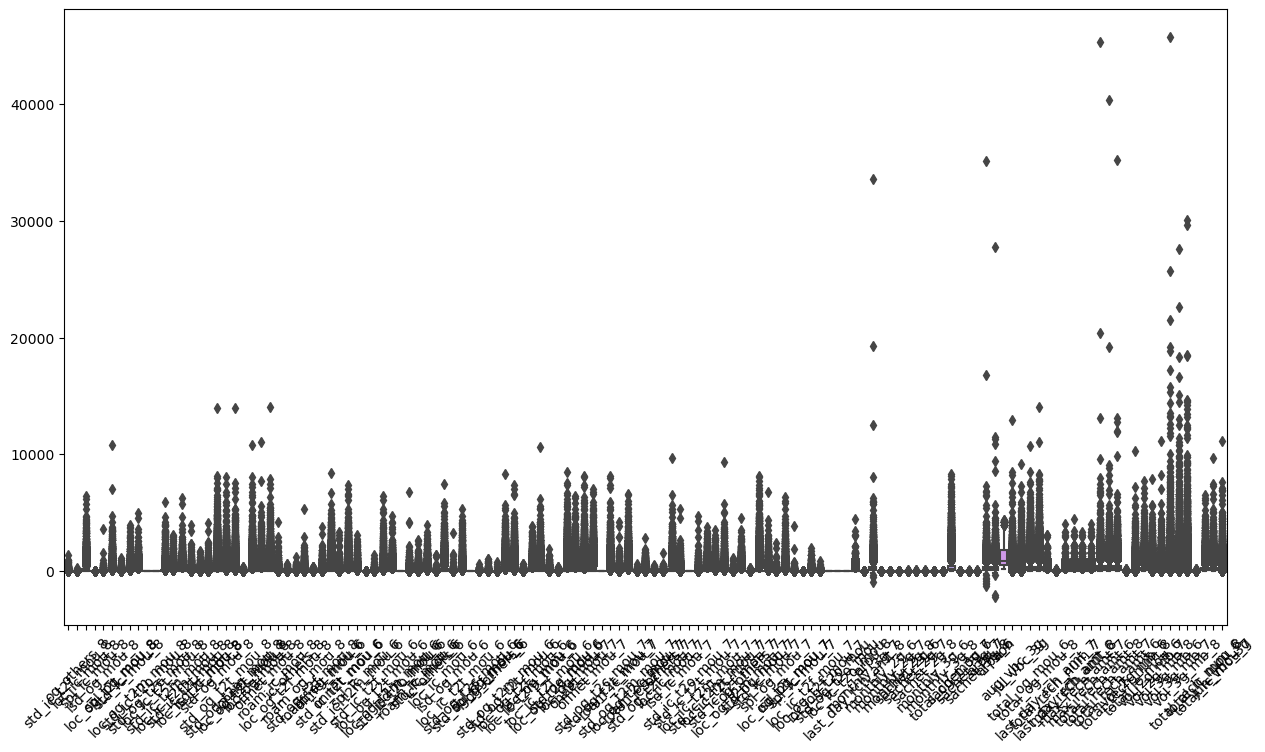

In [21]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be handled capping them to 25% and 75% quartiles .

In [22]:
# percentile list
perc = [.05, .25, .50, .75, .80, .95]
X_train_filtered_Describe = X_train_filtered.describe(percentiles=perc)
numericColumns = X_train_filtered_Describe.columns
print(numericColumns)
X_train_filtered_Describe

Index(['std_ic_t2f_mou_8', 'og_others_8', 'loc_ic_mou_8', 'spl_ic_mou_8',
       'isd_og_mou_8', 'loc_og_t2t_mou_8', 'spl_og_mou_8', 'std_ic_mou_8',
       'loc_og_t2m_mou_8', 'std_ic_t2o_mou_8',
       ...
       'total_ic_mou_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'total_rech_num_6', 'total_ic_mou_8',
       'total_ic_mou_7', 'jun_vbc_3g'],
      dtype='object', length=133)


std_ic_t2f_mou_8   og_others_8  loc_ic_mou_8  spl_ic_mou_8  \
count      55999.000000  55999.000000  55999.000000  55999.000000   
mean           1.995127      0.028162    158.367225      0.038308   
std           15.806045      1.741992    245.125526      0.148577   
min            0.000000      0.000000      0.000000      0.000000   
5%             0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000     24.760000      0.000000   
50%            0.000000      0.000000     84.580000      0.000000   
75%            0.000000      0.000000    197.510000      0.000000   
80%            0.150000      0.000000    237.968000      0.000000   
95%            7.880000      0.000000    554.435000      0.300000   
max         1394.890000    286.360000   6458.280000     16.860000   

       isd_og_mou_8  loc_og_t2t_mou_8  spl_og_mou_8  std_ic_mou_8  \
count  55999.000000      55999.000000  55999.000000   55999.00000   
mean       0.699333         42.997869      4.845460      31.46372   
std       20.209555        145.094410     18.051125     104.44242   
min        0.000000          0.000000      0.000000       0.00000   
5%         0.000000          0.000000      0.000000       0.00000   
25%        0.000000          0.780000      0.000000       0.00000   
50%        0.000000         10.110000      0.000000       4.69000   
75%        0.000000         37.310000      3.560000      25.61000   
80%        0.000000         48.990000      5.490000      35.23000   
95%        0.000000        166.917000     23.201000     131.48600   
max     3629.910000      10752.560000   1075.080000    3930.24000   

       loc_og_t2m_mou_8  std_ic_t2o_mou_8  ...  total_ic_mou_6   vol_2g_mb_7  \
count      55999.000000           55999.0  ...    55999.000000  55999.000000   
mean          86.033397               0.0  ...      199.972396     51.231798   
std          150.006129               0.0  ...      291.482136    212.874644   
min            0.000000               0.0  ...        0.000000      0.000000   
5%             0.000000               0.0  ...        0.000000      0.000000   
25%            6.410000               0.0  ...       38.635000      0.000000   
50%           35.810000               0.0  ...      114.880000      0.000000   
75%          102.860000               0.0  ...      251.340000      0.000000   
80%          128.542000               0.0  ...      298.356000      3.304000   
95%          336.362000               0.0  ...      670.850000    314.343000   
max         4961.330000               0.0  ...     7716.140000   7873.550000   

        vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000   
mean      50.180530    123.936335    129.450929    135.908424   
std      215.667832    567.967322    544.704714    568.633073   
min        0.000000      0.000000      0.000000      0.000000   
5%         0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000   
80%        3.830000      0.000000      0.000000      0.000000   
95%      302.284000    839.238000    871.007000    905.906000   
max    11117.610000  45735.400000  27600.290000  30036.060000   

       total_rech_num_6  total_ic_mou_8  total_ic_mou_7    jun_vbc_3g  
count      55999.000000    55999.000000    55999.000000  55999.000000  
mean           7.536117      198.720158      201.949991     61.095175  
std            6.997056      288.309042      295.795451    263.397967  
min            0.000000        0.000000        0.000000      0.000000  
5%             1.000000        0.000000        0.000000      0.000000  
25%            3.000000       38.240000       41.010000      0.000000  
50%            6.000000      114.340000      116.160000      0.000000  
75%            9.000000      24

In [23]:
#function for handling outliers
#Here we have considered 25th percentile as Q1 and 75th percentile as Q2.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [24]:
#Detecting the outliers
outliers = []
# Outlier detection for continuous variables
for col in numericColumns:
    isOutLierDetected = check_outlier(X_train_filtered, col)
    print(f"{col} :  {isOutLierDetected}")
    outliers.append(isOutLierDetected)
    
print(f"Outliers detected? {np.array(outliers).any()}")

std_ic_t2f_mou_8 :  True
og_others_8 :  True
loc_ic_mou_8 :  True
spl_ic_mou_8 :  True
isd_og_mou_8 :  True
loc_og_t2t_mou_8 :  True
spl_og_mou_8 :  True
std_ic_mou_8 :  True
loc_og_t2m_mou_8 :  True
std_ic_t2o_mou_8 :  False
std_og_t2c_mou_8 :  False
loc_ic_t2t_mou_8 :  True
std_ic_t2m_mou_8 :  True
loc_ic_t2m_mou_8 :  True
std_ic_t2t_mou_8 :  True
loc_ic_t2f_mou_8 :  True
isd_ic_mou_8 :  True
std_og_mou_8 :  True
std_og_t2t_mou_8 :  True
std_og_t2m_mou_8 :  True
loc_og_t2c_mou_8 :  True
onnet_mou_8 :  True
loc_og_mou_8 :  True
offnet_mou_8 :  True
roam_ic_mou_8 :  True
loc_og_t2f_mou_8 :  True
ic_others_8 :  True
roam_og_mou_8 :  True
std_og_t2f_mou_8 :  True
roam_og_mou_6 :  True
offnet_mou_6 :  True
std_ic_t2t_mou_6 :  True
onnet_mou_6 :  True
std_ic_t2m_mou_6 :  True
spl_ic_mou_6 :  True
std_ic_t2f_mou_6 :  True
loc_og_t2t_mou_6 :  True
loc_og_t2m_mou_6 :  True
std_ic_t2o_mou_6 :  False
isd_ic_mou_6 :  True
roam_ic_mou_6 :  True
std_ic_mou_6 :  True
ic_others_6 :  True
loc_ic_mou_

In [25]:
for col in numericColumns:
    replace_with_thresholds(X_train_filtered,col)

In [26]:
perc = [.05, .25, .50, .75, .80, .95]
X_train_filtered_Describe = X_train_filtered.describe(percentiles=perc)
X_train_filtered_Describe

std_ic_t2f_mou_8  og_others_8  loc_ic_mou_8  spl_ic_mou_8  \
count           55999.0      55999.0  55999.000000       55999.0   
mean                0.0          0.0    133.243511           0.0   
std                 0.0          0.0    137.465690           0.0   
min                 0.0          0.0      0.000000           0.0   
5%                  0.0          0.0      0.000000           0.0   
25%                 0.0          0.0     24.760000           0.0   
50%                 0.0          0.0     84.580000           0.0   
75%                 0.0          0.0    197.510000           0.0   
80%                 0.0          0.0    237.968000           0.0   
95%                 0.0          0.0    456.635000           0.0   
max                 0.0          0.0    456.635000           0.0   

       isd_og_mou_8  loc_og_t2t_mou_8  spl_og_mou_8  std_ic_mou_8  \
count       55999.0      55999.000000  55999.000000  55999.000000   
mean            0.0         24.603322      2.179718     16.511617   
std             0.0         30.837173      3.318492     22.257176   
min             0.0          0.000000      0.000000      0.000000   
5%              0.0          0.000000      0.000000      0.000000   
25%             0.0          0.780000      0.000000      0.000000   
50%             0.0         10.110000      0.000000      4.690000   
75%             0.0         37.310000      3.560000     25.610000   
80%             0.0         48.990000      5.490000     35.230000   
95%             0.0         92.105000      8.900000     64.025000   
max             0.0         92.105000      8.900000     64.025000   

       loc_og_t2m_mou_8  std_ic_t2o_mou_8  ...  total_ic_mou_6  vol_2g_mb_7  \
count      55999.000000           55999.0  ...    55999.000000      55999.0   
mean          68.244542               0.0  ...      171.117723          0.0   
std           78.541449               0.0  ...      169.410906          0.0   
min            0.000000               0.0  ...        0.000000          0.0   
5%             0.000000               0.0  ...        0.000000          0.0   
25%            6.410000               0.0  ...       38.635000          0.0   
50%           35.810000               0.0  ...      114.880000          0.0   
75%          102.860000               0.0  ...      251.340000          0.0   
80%          128.542000               0.0  ...      298.356000          0.0   
95%          247.535000               0.0  ...      570.397500          0.0   
max          247.535000               0.0  ...      570.397500          0.0   

       vol_2g_mb_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  total_rech_num_6  \
count      55999.0      55999.0      55999.0      55999.0      55999.000000   
mean           0.0          0.0          0.0          0.0          6.938963   
std            0.0          0.0          0.0          0.0          4.830058   
min            0.0          0.0          0.0          0.0          0.000000   
5%             0.0          0.0          0.0          0.0          1.000000   
25%            0.0          0.0          0.0          0.0          3.000000   
50%            0.0          0.0          0.0          0.0          6.000000   
75%            0.0          0.0          0.0          0.0          9.000000   
80%            0.0          0.0          0.0          0.0         11.000000   
95%            0.0          0.0          0.0          0.0         18.000000   
max            0.0          0.0          0.0          0.0         18.000000   

       total_ic_mou_8  total_ic_mou_7  jun_vbc_3g  
count    55999.000000    55999.000000     55999.0  
mean       169.722540      171.468267         0.0  
std        168.066966      167.567292         0.0  
min          0.000000        0.000000         0.0  
5%           0.000000        0.000000         0.0  
25%         38.240000       41.010000         0.0  
50%        114.340000      116.160000         0.0  
75%        249.170000      249.635000         0

<Axes: >

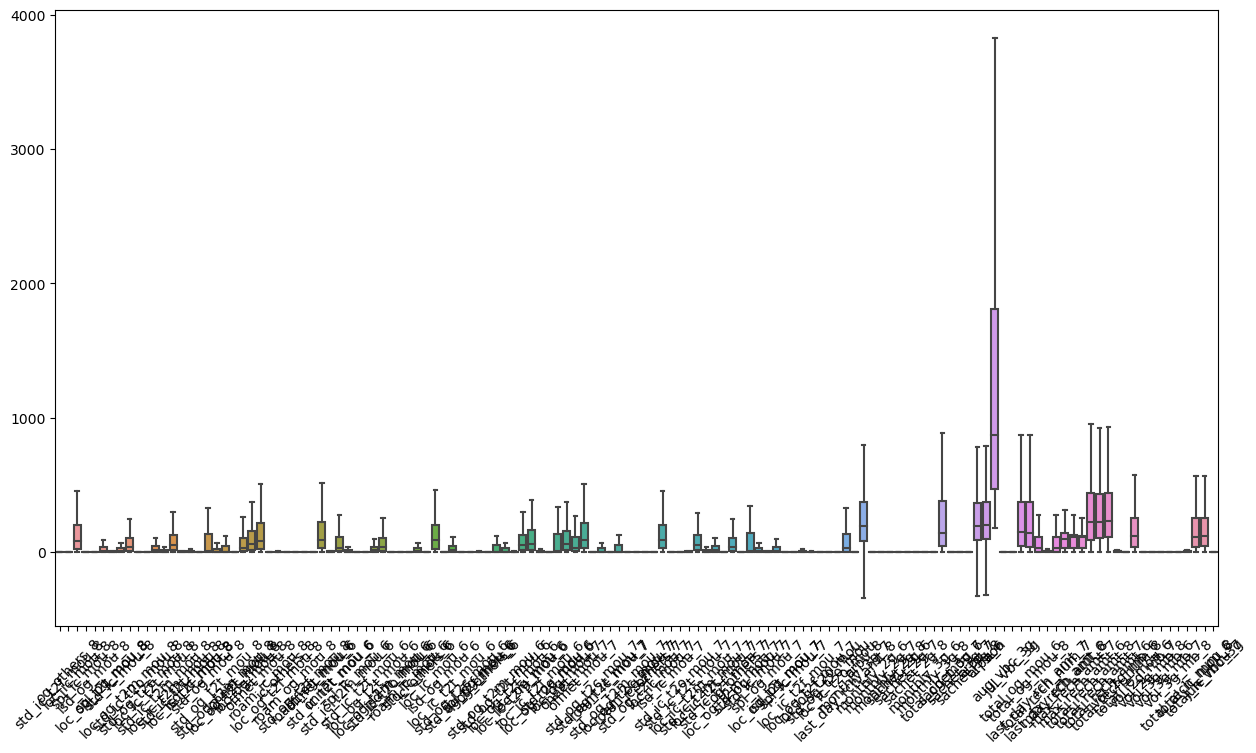

In [27]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [28]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered)

<Axes: >

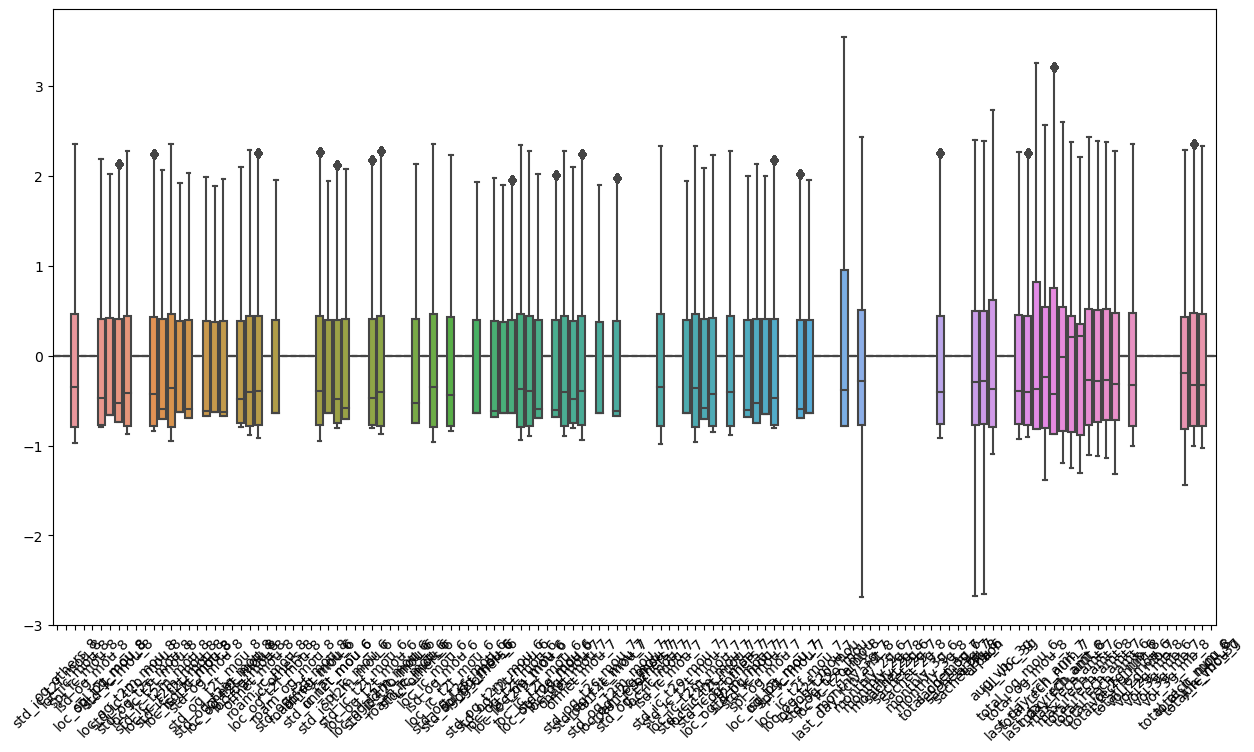

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

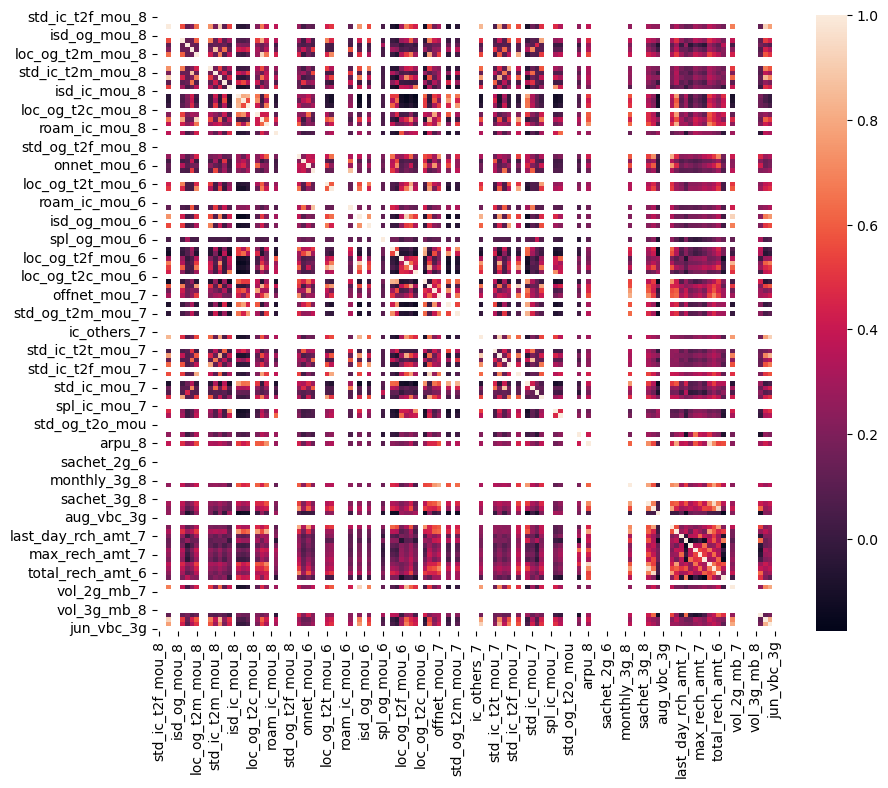

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

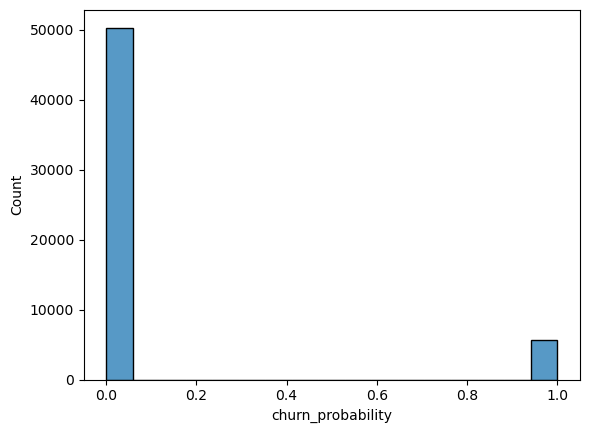

In [31]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [32]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [33]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 133 artists>

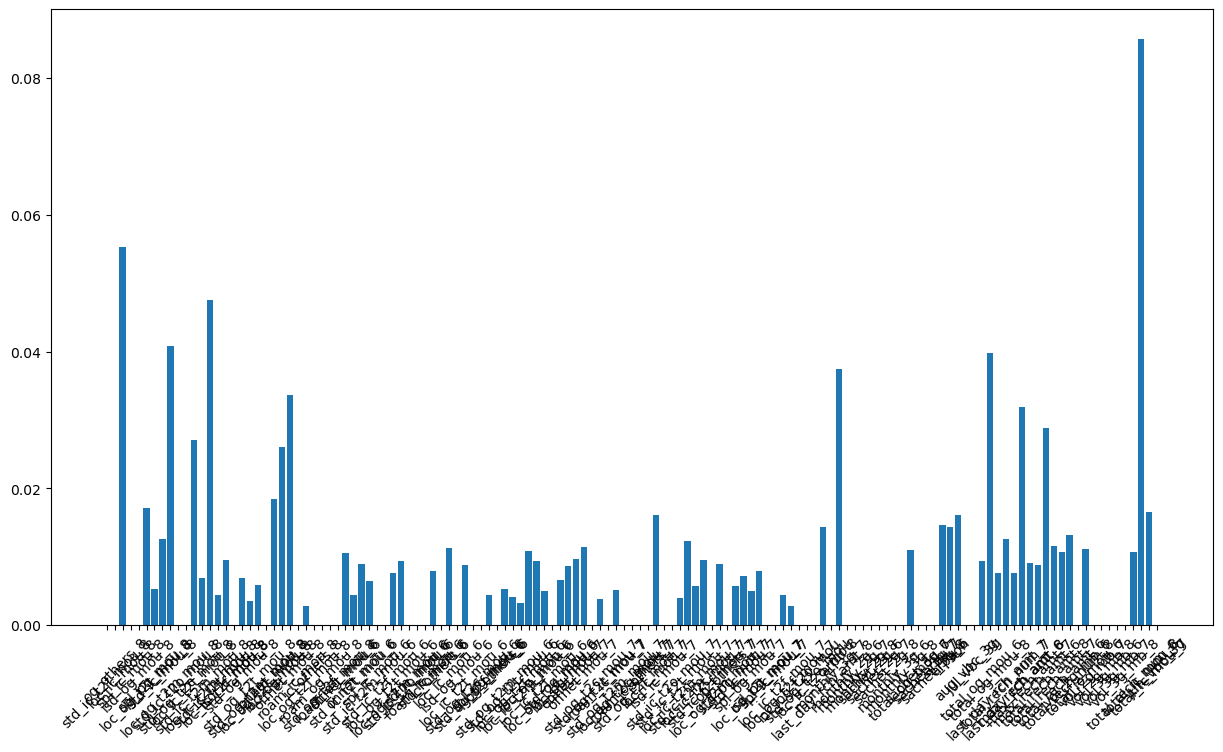

In [34]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

We will be using Principal component Analysis for feature reduction

<Axes: >

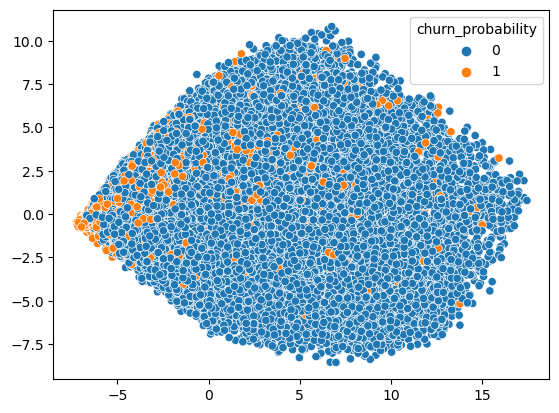

In [35]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

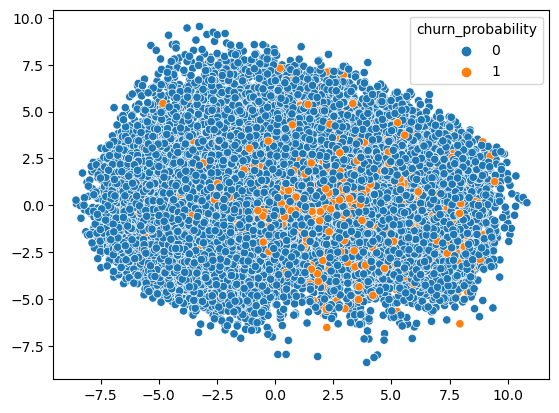

In [36]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [37]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.29434064 0.44995077 0.51232965 0.56471205 0.61267321 0.65073296
 0.67835573 0.70331959 0.72700299 0.75026557 0.77034037 0.78729272
 0.79936679 0.81096906 0.82182522 0.83235813 0.84284123 0.85310309
 0.86200928 0.87022471 0.87716445 0.8837631  0.89023043 0.89647826
 0.90225226 0.90791233 0.91353465 0.91896754 0.9238222  0.92832434
 0.93263184 0.93693622 0.94107161 0.94507942 0.94868783 0.95218105
 0.95553264 0.95870053 0.96166822 0.96460642 0.96745228 0.97014366
 0.97277827 0.9752317  0.97738477 0.97937383 0.9812731  0.98305229
 0.98476614 0.98619336 0.98753262 0.98873743 0.98981971 0.99067365
 0.99151795 0.99235085 0.99314708 0.99383809 0.99452471 0.99517846
 0.99578204 0.996359   0.99691439 0.99745982 0.99787639 0.998284
 0.99868884 0.99906778 0.99936357 0.99956462 0.99973462 0.99987548
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.       

From the cumulative variance we can observe that 66 features explain 99% variance hence we can choose 66 features
Also let us plot Scree Plot to check this visually

Text(0, 0.5, 'Cumulative Variance')

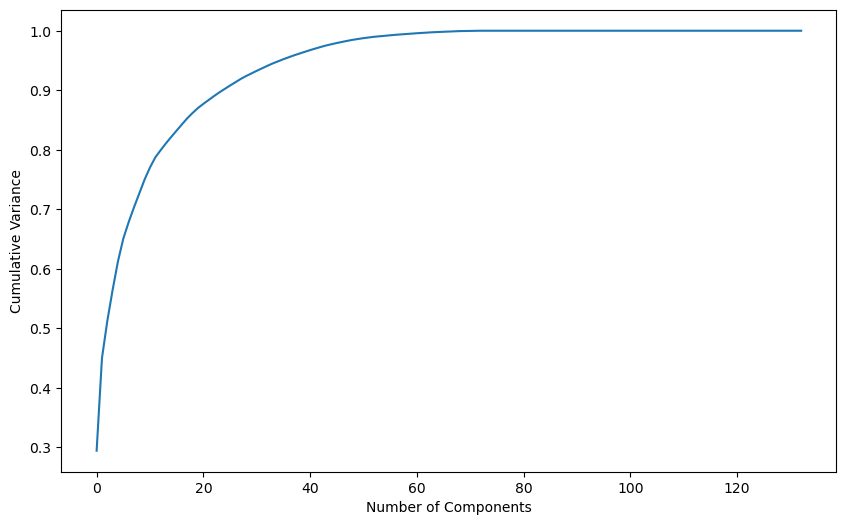

In [38]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

# 6. Model building



The steps of this pipeline would be the following.
1. Imputation
2. Scaling
3. PCA
4. Classification model with GridSearchCV used for hyper parameter tuning

In [39]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=66, )
#lr = LogisticRegression(max_iter=1000, tol=0.001)#LogisticRegression(max_iter=1000, tol=0.001)

In [40]:
lr_pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model', GridSearchCV(LogisticRegression(),
                                     param_grid={"C": [0.01, 0.1, 1, 10, 100, 1000]},
                                     cv=4, n_jobs=-1, verbose=1, scoring = "accuracy",
                                     refit=True))
                        ]
               )

In [41]:
lr_pipe.fit(X_train[new_vars], y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=66)),
                ('model',
                 GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
                              scoring='accuracy', verbose=1))])

In [42]:
param_grid = {
    'max_depth': [5,10,15,20],
    'min_samples_leaf': [50,100,150],
    'criterion': ["gini", "entropy"]
}
dt_pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model', GridSearchCV(DecisionTreeClassifier(),
                                     param_grid=param_grid,
                                     cv=4, n_jobs=-1, verbose=1, scoring = "accuracy",
                                     refit=True))
                        ]
               )

In [43]:
dt_pipe.fit(X_train[new_vars], y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=66)),
                ('model',
                 GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [5, 10, 15, 20],
                                          'min_samples_leaf': [50, 100, 150]},
                              scoring='accuracy', verbose=1))])

In [44]:
param_grid = {
    'max_depth': [5,10,15,20],
    'min_samples_leaf': [50,100,150],
    'n_estimators': [10, 25, 50, 100]
}

rf_pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model', GridSearchCV(RandomForestClassifier(),
                                     param_grid=param_grid,
                                     cv=4, n_jobs=-1, verbose=1, scoring = "accuracy",
                                     refit=True))
                        ]
               )

In [45]:
rf_pipe.fit(X_train[new_vars], y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=66)),
                ('model',
                 GridSearchCV(cv=4, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15, 20],
                                          'min_samples_leaf': [50, 100, 150],
                                          'n_estimators': [10, 25, 50, 100]},
                              scoring='accuracy', verbose=1))])

Let's make a confusion matrix and derive different metrices to analyze the model is performing.

In [46]:
def buildMetricsFromconfudionMatrix(confusion, columnName, y, y_pred):
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # Accuracy
    accuracy = metrics.accuracy_score(y, y_pred)

    # Sensitivity/Recall
    sensitivity = TP / float(TP+FN)

    # Specificity
    specificity = TN / float(TN+FP)

    # Precission
    precission = TP / float(TP+FP)
    
    metric = pd.DataFrame()
    metric['Metric'] = ['Accuracy','Sensitivity','Specificity','Precission']
    metric[columnName] = [accuracy,sensitivity,specificity,precission]
    
    return metric
    

In [47]:
def getConfusionMetrics(model,x_train,y_train,x_test,y_test, train_columnName, test_columnName):
    y_train_pred = model.predict(x_train)
    train_confusion = confusion_matrix(y_train, y_train_pred)
        
    y_test_pred = model.predict(x_test)
    test_confusion = confusion_matrix(y_test, y_test_pred)
        
    train_metrics = buildMetricsFromconfudionMatrix(train_confusion,train_columnName,y_train, y_train_pred)
    test_metrics = buildMetricsFromconfudionMatrix(test_confusion,test_columnName,y_test, y_test_pred)
    
    model_metrics = train_metrics.join(test_metrics.set_index('Metric'), on='Metric', validate='1:1')
    
    return train_confusion,test_confusion,model_metrics
    

In [48]:
lr_train_confusion, lr_test_confusion,  lr_metrics = getConfusionMetrics(lr_pipe,X_train[new_vars],y_train,X_test[new_vars],y_test,'LR_Train','LR_Test')
print('Logistic Regression-Train Confusion Matrix:')
print(lr_train_confusion)
print('\nLogistic Regression-Test Confusion Matrix:')
print(lr_test_confusion)
print('\nLogistic Regression-Model Metrics:')
print(lr_metrics)

Logistic Regression-Train Confusion Matrix:
[[49690   626]
 [ 4206  1477]]

Logistic Regression-Test Confusion Matrix:
[[12384   167]
 [ 1089   360]]

Logistic Regression-Model Metrics:
        Metric  LR_Train   LR_Test
0     Accuracy  0.913713  0.910286
1  Sensitivity  0.259898  0.248447
2  Specificity  0.987559  0.986694
3   Precission  0.702330  0.683112


In [49]:
dt_train_confusion, dt_test_confusion,  dt_metrics = getConfusionMetrics(dt_pipe,X_train[new_vars],y_train,X_test[new_vars],y_test,'DT_Train','DT_Test')
print('Decission Tree-Train Confusion Matrix:')
print(dt_train_confusion)
print('\nDecission Tree-Test Confusion Matrix:')
print(dt_test_confusion)
print('\nDecission Tree-Model Metrics:')
print(dt_metrics)

Decission Tree-Train Confusion Matrix:
[[49012  1304]
 [ 3084  2599]]

Decission Tree-Test Confusion Matrix:
[[12161   390]
 [  857   592]]

Decission Tree-Model Metrics:
        Metric  DT_Train   DT_Test
0     Accuracy  0.921641  0.910929
1  Sensitivity  0.457329  0.408558
2  Specificity  0.974084  0.968927
3   Precission  0.665898  0.602851


In [50]:
rf_train_confusion, rf_test_confusion,  rf_metrics = getConfusionMetrics(rf_pipe,X_train[new_vars],y_train,X_test[new_vars],y_test,'RF_Train','RF_Test')
print('Random Forest-Train Confusion Matrix:')
print(rf_train_confusion)
print('\nRandom Forest-Test Confusion Matrix:')
print(rf_test_confusion)
print('\nRandom Forest-Model Metrics:')
print(rf_metrics)

Random Forest-Train Confusion Matrix:
[[50051   265]
 [ 4403  1280]]

Random Forest-Test Confusion Matrix:
[[12465    86]
 [ 1181   268]]

Random Forest-Model Metrics:
        Metric  RF_Train   RF_Test
0     Accuracy  0.916641  0.909500
1  Sensitivity  0.225233  0.184955
2  Specificity  0.994733  0.993148
3   Precission  0.828479  0.757062


We can see a that all the models are giving the the similar scores. So we will be selecting less complex model Logistic regression for further study

### <font color = blue>Logistic regression is the final model</font>

In [58]:
finalModel = lr_pipe.named_steps['model'].best_estimator_
finalModel

LogisticRegression(C=10)

### Plotting the ROC Curve
An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [59]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [79]:
model_probs = lr_pipe.predict_proba(X_train[new_vars])
y_score = model_probs[:, 1]
fpr, tpr,thresholds = metrics.roc_curve(y_train, y_score,drop_intermediate = False)

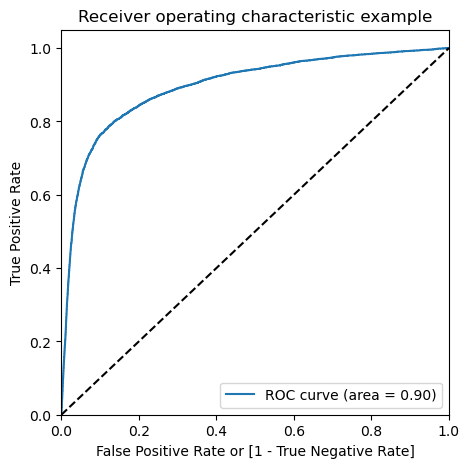

In [80]:
draw_roc(y_train, y_score)

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [51]:
unseen.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [52]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 133)

lets use the model pipeline to predict the probabilities for this data
### <font color = blue>Final Prediction by Logistic regression</font>

In [53]:
lr_unseen = unseen[['id']]
lr_unseen['churn_probability'] = lr_pipe.predict(submission_data)
#Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.
lr_unseen.to_csv('lr_unseen_Prediction.csv',index=False)
lr_unseen.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [54]:
dt_unseen = unseen[['id']]
dt_unseen['churn_probability'] = dt_pipe.predict(submission_data)
#Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.
dt_unseen.to_csv('dt_unseen_Prediction.csv',index=False)
dt_unseen.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [55]:
rf_unseen = unseen[['id']]
rf_unseen['churn_probability'] = rf_pipe.predict(submission_data)
#Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.
rf_unseen.to_csv('rf_unseen_Prediction.csv',index=False)
rf_unseen.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

You can now take this file and upload it as a submission on Kaggle.